In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv(r'/Users/biplavbarua/Developer/Real_time_Air_Quality_Index_from_various_locations.csv')

# Display the first few rows
print("Dataset preview:")
print(df.head())

Dataset preview:
  country           state           city  \
0   India  Andhra_Pradesh       Tirupati   
1   India  Andhra_Pradesh       Tirupati   
2   India  Andhra_Pradesh     Vijayawada   
3   India  Andhra_Pradesh     Vijayawada   
4   India  Andhra_Pradesh  Visakhapatnam   

                                  station          last_update   latitude  \
0         Vaikuntapuram, Tirupati - APPCB  12-04-2025 10:00:00  13.615387   
1         Vaikuntapuram, Tirupati - APPCB  12-04-2025 10:00:00  13.615387   
2   Rajiv Gandhi Park, Vijayawada - APPCB  12-04-2025 10:00:00  16.509717   
3   Rajiv Gandhi Park, Vijayawada - APPCB  12-04-2025 10:00:00  16.509717   
4  GVM Corporation, Visakhapatnam - APPCB  12-04-2025 10:00:00  17.720000   

   longitude pollutant_id  pollutant_min  pollutant_max  pollutant_avg  
0  79.409230          SO2            NaN            NaN            NaN  
1  79.409230        OZONE            NaN            NaN            NaN  
2  80.612222           CO           

In [2]:
# Convert timestamp to datetime if needed (assuming a column named 'timestamp' or 'date_time' exists)
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
elif 'date_time' in df.columns:
    df['date_time'] = pd.to_datetime(df['date_time'])

# Check for missing values
print("\nMissing values summary:")
print(df.isnull().sum())

# Optionally, drop or impute missing values
df = df.dropna()  # or consider imputation strategies

# Display basic descriptive statistics
print("\nDescriptive statistics:")
print(df.describe())


Missing values summary:
country            0
state              0
city               0
station            0
last_update        0
latitude           0
longitude          0
pollutant_id       0
pollutant_min    331
pollutant_max    331
pollutant_avg    331
dtype: int64

Descriptive statistics:
          latitude    longitude  pollutant_min  pollutant_max  pollutant_avg
count  2888.000000  2888.000000    2888.000000    2888.000000    2888.000000
mean     22.293654    78.674758      19.198753      71.339335      34.631579
std       5.531398     4.920012      19.775042      88.711091      33.526213
min       8.514909    70.909168       1.000000       1.000000       1.000000
25%      19.036458    75.555917       5.000000      17.000000      10.000000
50%      23.032263    77.400574      13.000000      45.000000      24.000000
75%      26.811237    80.854941      27.000000      90.000000      48.000000
max      34.066206    94.636574     336.000000     500.000000     336.000000


In [6]:
# Define AQI computation functions using EPA breakpoints.
def compute_aqi_pm25(pm25):
    """
    Compute a simplified AQI using PM2.5 concentration based on EPA breakpoints.
    This function uses linear interpolation between breakpoints.
    """
    breakpoints = [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 350.4, 301, 400),
        (350.5, 500.4, 401, 500),
    ]
    aqi = None
    for bp in breakpoints:
        bp_low, bp_high, aqi_low, aqi_high = bp
        if bp_low <= pm25 <= bp_high:
            aqi = ((aqi_high - aqi_low) / (bp_high - bp_low)) * (pm25 - bp_low) + aqi_low
            break
    return int(aqi) if aqi is not None else -1

def compute_aqi_pm10(pm10):
    """
    Compute a simplified AQI using PM10 concentration based on EPA breakpoints.
    Breakpoints for PM10 (in µg/m^3) are approximate.
    """
    breakpoints = [
        (0, 54, 0, 50),
        (55, 154, 51, 100),
        (155, 254, 101, 150),
        (255, 354, 151, 200),
        (355, 424, 201, 300),
        (425, 504, 301, 400),
        (505, 604, 401, 500),
    ]
    aqi = None
    for bp in breakpoints:
        bp_low, bp_high, aqi_low, aqi_high = bp
        if bp_low <= pm10 <= bp_high:
            aqi = ((aqi_high - aqi_low) / (bp_high - bp_low)) * (pm10 - bp_low) + aqi_low
            break
    return int(aqi) if aqi is not None else -1

def compute_aqi(row):
    """
    Compute AQI based on the pollutant type and its average value.
    - For PM2.5, use the PM2.5 AQI function.
    - For PM10, use the PM10 AQI function.
    For unknown pollutant types, return -1.
    """
    # Ensure pollutant_id is a string and remove potential leading/trailing spaces.
    pollutant = str(row['pollutant_id']).strip().upper()
    value = row['pollutant_avg']
    
    # Check pollutant type and compute AQI accordingly.
    if pollutant in ['PM2.5', 'PM2_5', 'PM25']:
        return compute_aqi_pm25(value)
    elif pollutant == 'PM10':
        return compute_aqi_pm10(value)
    else:
        # For pollutants we do not have a function for, return -1 as a placeholder.
        return -1

# Compute the AQI using the pollutant_id and pollutant_avg columns.
df['AQI'] = df.apply(compute_aqi, axis=1)

# Check the results: display rows with valid AQI values (i.e. AQI not equal to -1)
print("Sample of computed AQI values (for rows with known pollutant types):")
print(df[df['AQI'] != -1][['pollutant_id', 'pollutant_avg', 'AQI']].head())


Sample of computed AQI values (for rows with known pollutant types):
   pollutant_id  pollutant_avg  AQI
4          PM10           85.0   65
13        PM2.5           60.0  153
17        PM2.5          163.0  213
20         PM10           96.0   71
25        PM2.5           46.0  126


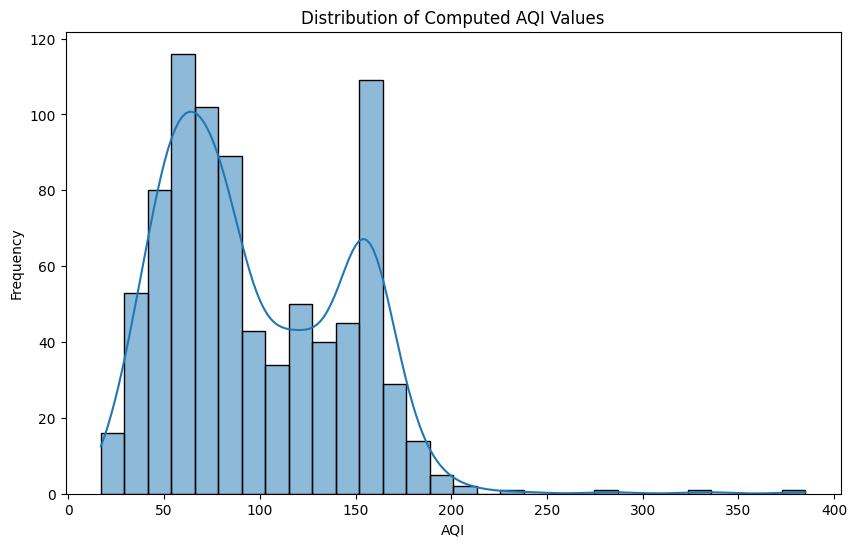

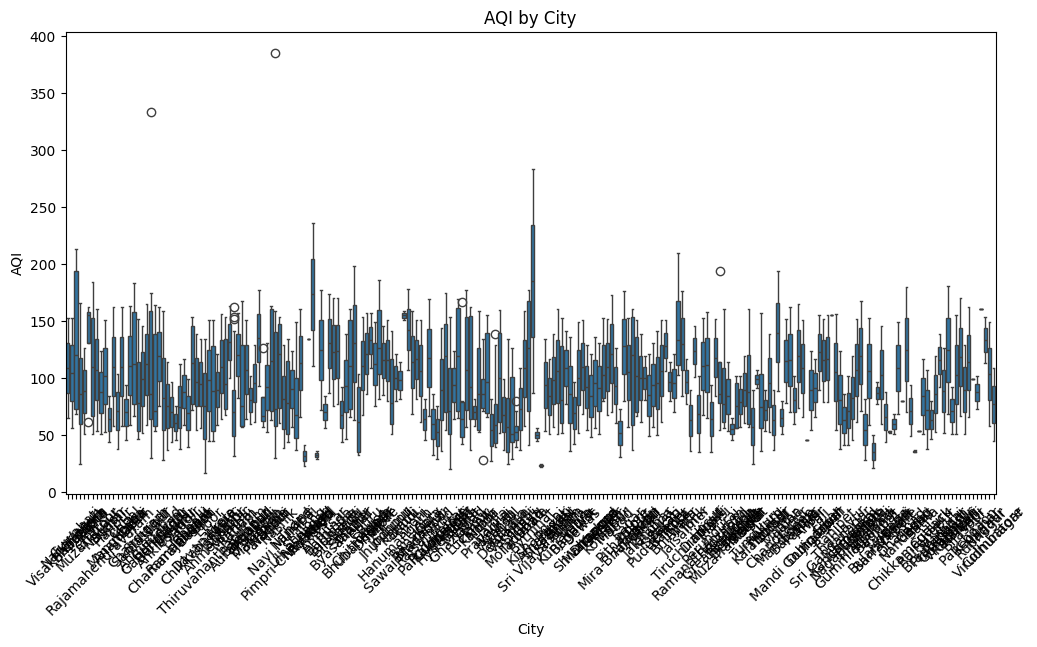

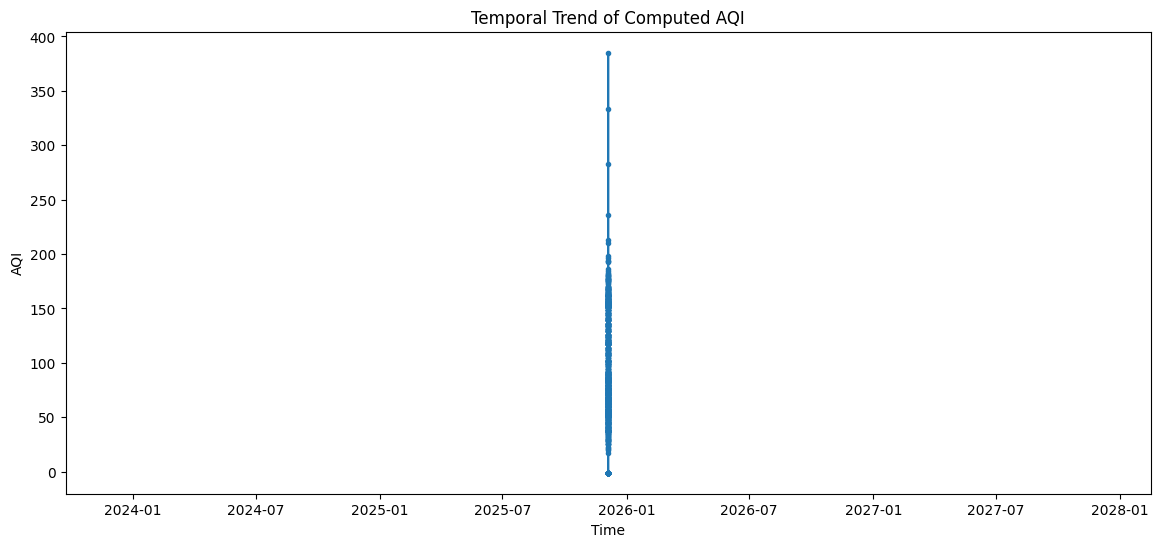

In [7]:
# Ensure any date/time column is formatted correctly (we use the 'last_update' column here if available)
if 'last_update' in df.columns:
    df['last_update'] = pd.to_datetime(df['last_update'])

# 1. Distribution of AQI:
plt.figure(figsize=(10, 6))
sns.histplot(df['AQI'][df['AQI'] != -1], bins=30, kde=True)
plt.title('Distribution of Computed AQI Values')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()

# 2. Geographical Distribution:
# For example, let's use the 'city' column to observe regional differences.
if 'city' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[df['AQI'] != -1], x='city', y='AQI')
    plt.title('AQI by City')
    plt.xticks(rotation=45)
    plt.xlabel('City')
    plt.ylabel('AQI')
    plt.show()

# 3. Temporal Trends:
# If 'last_update' or an equivalent date/time column is available, explore temporal trends.
if 'last_update' in df.columns:
    df_sorted = df.sort_values(by='last_update')
    
    # Plot AQI over time for rows with a valid AQI value
    plt.figure(figsize=(14, 6))
    plt.plot(df_sorted['last_update'], df_sorted['AQI'], linestyle='-', marker='o', markersize=3)
    plt.title('Temporal Trend of Computed AQI')
    plt.xlabel('Time')
    plt.ylabel('AQI')
    plt.show()


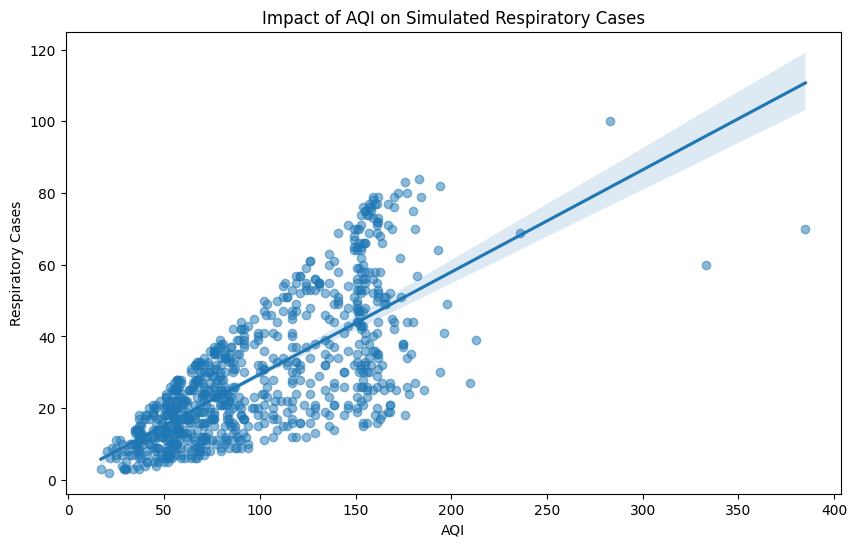

Correlation between AQI and respiratory cases: 0.72


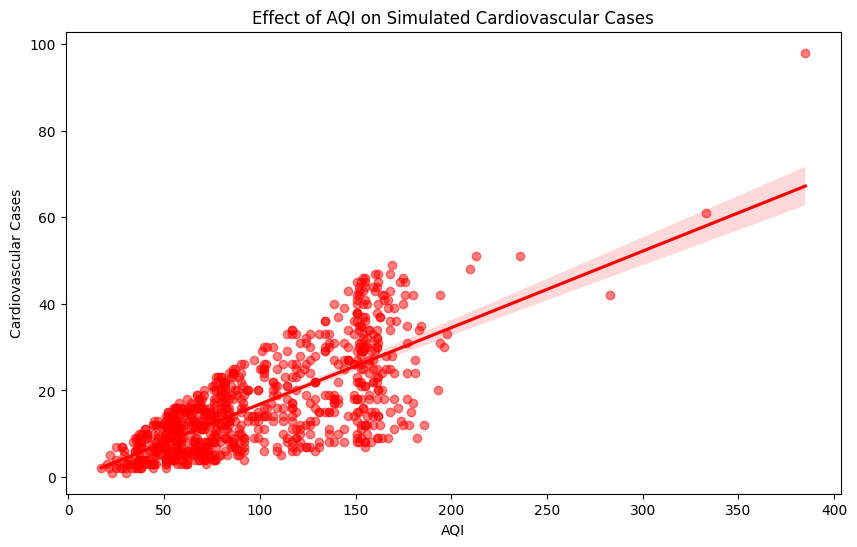

Correlation between AQI and cardiovascular cases: 0.73


In [ ]:
# ----------------------------
# Objective 4: Evaluate Urbanization/Industrialization Effects on Public Health
# ----------------------------

# Set random seed for reproducibility
np.random.seed(42)

# Simulate health outcomes:
# For demonstration, respiratory_cases and cardiovascular_cases are generated
# as functions of AQI with a random factor to introduce variability.
df['respiratory_cases'] = (df['AQI'] * np.random.uniform(0.1, 0.5, len(df))).astype(int)
df['cardiovascular_cases'] = (df['AQI'] * np.random.uniform(0.05, 0.3, len(df))).astype(int)

# 1. Assessing the Impact on Respiratory Diseases
plt.figure(figsize=(10, 6))
sns.regplot(x='AQI', y='respiratory_cases', data=df[df['AQI'] != -1], scatter_kws={'alpha':0.5})
plt.title('Impact of AQI on Simulated Respiratory Cases')
plt.xlabel('AQI')
plt.ylabel('Respiratory Cases')
plt.show()

# Calculate and print correlation for respiratory cases
corr_resp = df.loc[df['AQI'] != -1, 'AQI'].corr(df.loc[df['AQI'] != -1, 'respiratory_cases'])
print(f"Correlation between AQI and respiratory cases: {corr_resp:.2f}")

# 2. Evaluating the Effect on Cardiovascular Health
plt.figure(figsize=(10, 6))
sns.regplot(x='AQI', y='cardiovascular_cases', data=df[df['AQI'] != -1], scatter_kws={'alpha':0.5}, color='red')
plt.title('Effect of AQI on Simulated Cardiovascular Cases')
plt.xlabel('AQI')
plt.ylabel('Cardiovascular Cases')
plt.show()

# Calculate and print correlation for cardiovascular cases
corr_card = df.loc[df['AQI'] != -1, 'AQI'].corr(df.loc[df['AQI'] != -1, 'cardiovascular_cases'])
print(f"Correlation between AQI and cardiovascular cases: {corr_card:.2f}")



Predictive Model Evaluation:
Mean Squared Error: 164.38
R-squared: 0.54


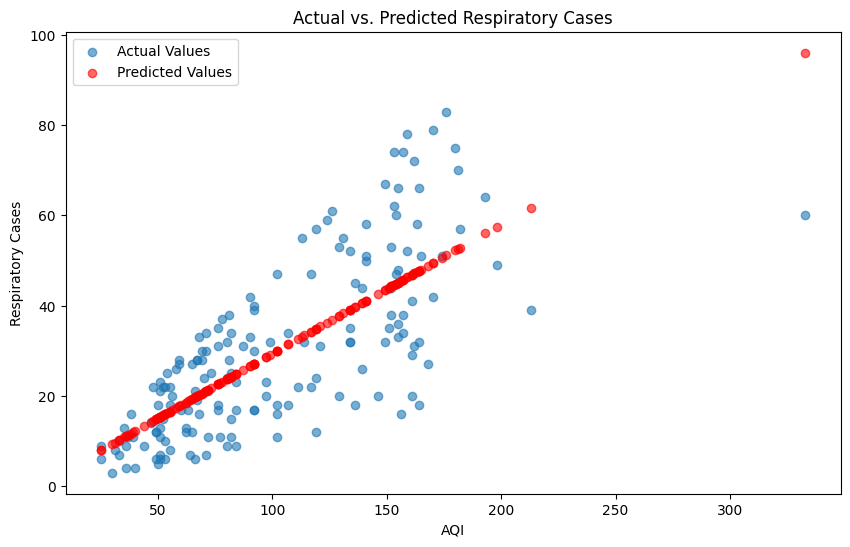

In [ ]:
# ----------------------------
# Objective 5: Develop Predictive Models for Health Outcomes Based on Air Quality Forecasts
# ----------------------------

# Prepare the dataset: use only rows with a valid AQI value.
df_valid = df[df['AQI'] != -1]

# Define the predictor variable (AQI) and target variable (respiratory_cases)
X = df_valid[['AQI']]
y = df_valid['respiratory_cases']

# Split the dataset into training and testing subsets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model with Mean Squared Error (MSE) and R-squared (R2) metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nPredictive Model Evaluation:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Visualize the relationship: scatter plot of actual vs. predicted respiratory cases
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, alpha=0.6, label='Actual Values')
plt.scatter(X_test, y_pred, alpha=0.6, label='Predicted Values', color='red')
plt.xlabel("AQI")
plt.ylabel("Respiratory Cases")
plt.title("Actual vs. Predicted Respiratory Cases")
plt.legend()
plt.show()


Area Type Value Counts:
area_type
Urban    2565
Rural     323
Name: count, dtype: int64


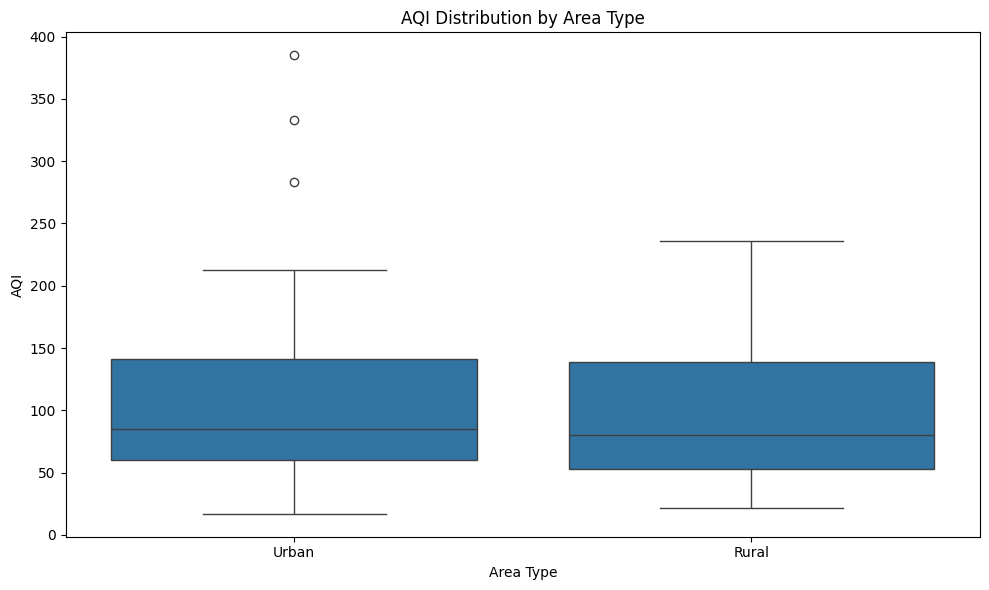

Mean Health Outcomes by Area Type:
  area_type  respiratory_cases  cardiovascular_cases
0     Rural          27.419355             15.473118
1     Urban          28.956640             16.508130


/var/folders/bw/5tc2sfgd3_dg6w_6rv0h5zq80000gn/T/ipykernel_27275/1252139354.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agg_health, x='area_type', y='cardiovascular_cases', palette='Reds', ax=axes[1])


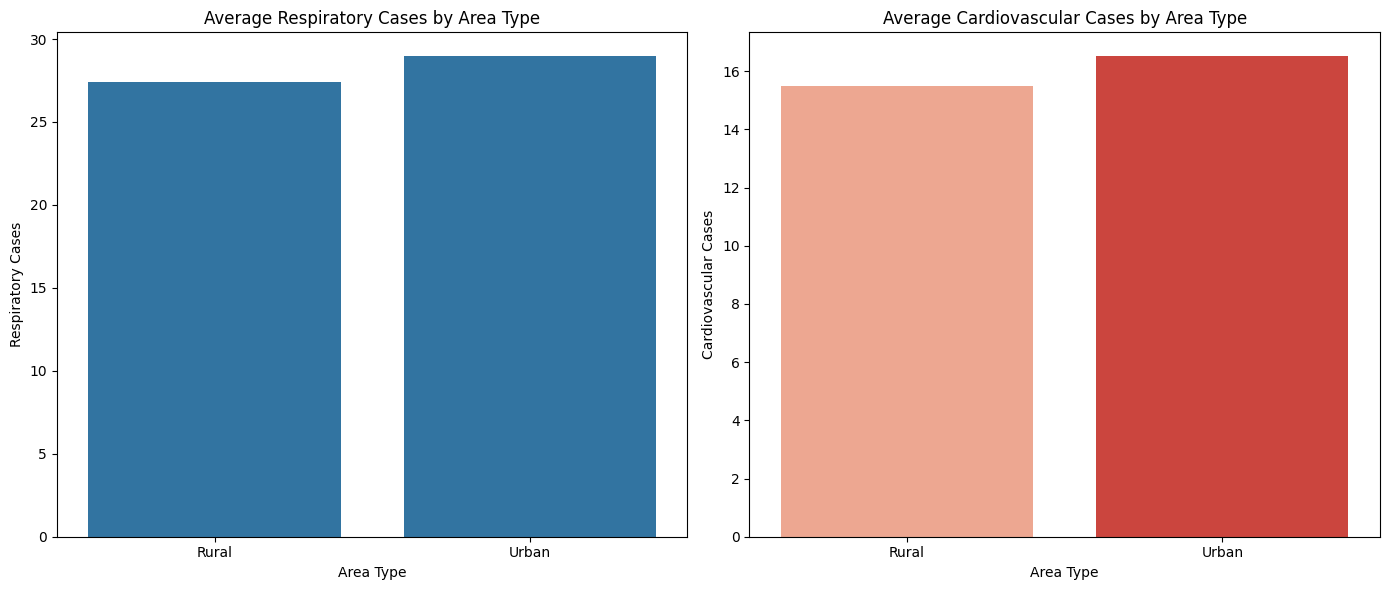

In [12]:
# ----------------------------
# Objective 6: Evaluate Urbanization/Industrialization Effects on Public Health
# ----------------------------

# Create a proxy for 'area_type' based on the dataset's 'city' frequency.
# This approach assumes that cities with more data entries are likely to be urban.
if 'city' not in df.columns:
    raise ValueError("No 'city' column available to derive urbanization information.")

# Calculate city frequency from the dataset.
city_counts = df['city'].value_counts()

# Determine a threshold based on the median count.
threshold = city_counts.median()

# Consider cities with a count >= threshold as 'Urban'; otherwise, 'Rural'.
urban_cities = city_counts[city_counts >= threshold].index.tolist()

# Create the 'area_type' column using the derived urban cities from the dataset.
df['area_type'] = df['city'].apply(lambda x: 'Urban' if x in urban_cities else 'Rural')

# Display the counts for each area type to check the classification.
print("Area Type Value Counts:")
print(df['area_type'].value_counts())

# Next, visualize AQI distribution across the derived area types (ignoring invalid AQI values marked as -1).
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[df['AQI'] != -1], x='area_type', y='AQI')
plt.title('AQI Distribution by Area Type')
plt.xlabel('Area Type')
plt.ylabel('AQI')
plt.tight_layout()
plt.show()

# Assuming that simulated health outcomes 'respiratory_cases' and 'cardiovascular_cases' have already been computed,
# aggregate the average health outcomes by area type.
agg_health = df[df['AQI'] != -1].groupby('area_type')[['respiratory_cases', 'cardiovascular_cases']].mean().reset_index()

print("Mean Health Outcomes by Area Type:")
print(agg_health)

# Create subplots for the two health outcomes.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Subplot for Average Respiratory Cases by Area Type
sns.barplot(data=agg_health, x='area_type', y='respiratory_cases', ax=axes[0])
axes[0].set_title('Average Respiratory Cases by Area Type')
axes[0].set_xlabel('Area Type')
axes[0].set_ylabel('Respiratory Cases')

# Subplot for Average Cardiovascular Cases by Area Type
sns.barplot(data=agg_health, x='area_type', y='cardiovascular_cases', palette='Reds', ax=axes[1])
axes[1].set_title('Average Cardiovascular Cases by Area Type')
axes[1].set_xlabel('Area Type')
axes[1].set_ylabel('Cardiovascular Cases')

plt.tight_layout()
plt.show()
